In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import sklearn.ensemble
from scipy import signal
from scipy.signal import argrelextrema
from dataread import *
from plots import *
from BollingerBand import *
from sklearn.metrics import confusion_matrix
import featuregeneration as fg
from fourier import FourierTransform
import RFFramework as rff
from sklearn.feature_selection import SelectKBest, chi2
from classifier import Classifier

In [2]:
train_df = preprocess(get_train_df())
standarized_train_df = preprocess(get_train_df(), 'standarize')

In [3]:
test_df = preprocess(get_test_df(), 'normalize')
standarized_test_df = preprocess(get_test_df(), 'standarize')

In [4]:
train_fourier = FourierTransform(standarized_train_df, detrend = False)
test_fourier = FourierTransform(standarized_test_df, detrend = False)

There is an exoplanet


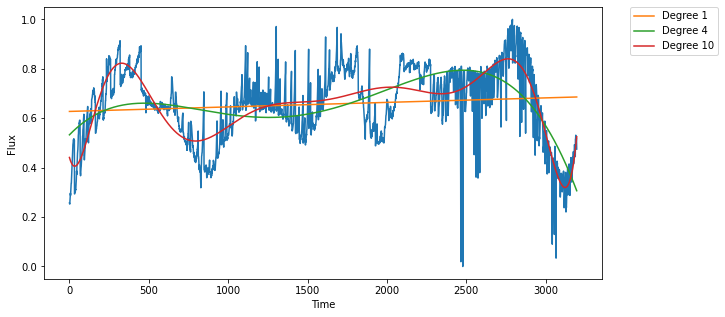

In [5]:
plot_row(train_df, 4)

There is an exoplanet
std =  54.015063676506045


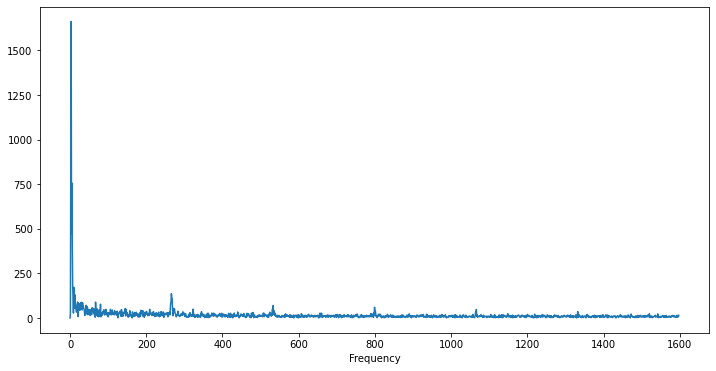

In [6]:
train_fourier.plot_row(row_index = 5, plot_source_values = False)

In [7]:
train_features = fg.get_df(train_df, standarized_train_df, train_fourier)
test_features = fg.get_df(test_df, standarized_test_df, test_fourier)

# AdaBoost

In [11]:
test = Classifier(sklearn.ensemble.AdaBoostClassifier, n_estimators = 1000)
test.fit_df(train_features)

In [12]:
test.predict_df(test_features)

array([1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

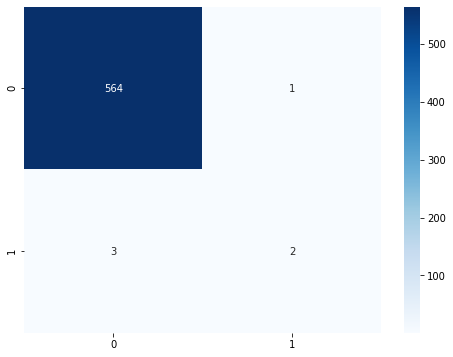

In [13]:
test.plot_cfm()

In [15]:
test.calculate_f_score()[0]

0.5